For inference, we use simulation-based inference (SBI) with neural posterior estimation, implemented via the package [ltu-ili](https://github.com/maho3/ltu-ili).

We consider two inference schemes:

1. **Direct inference of the neutral fraction:**  
   We train a neural density estimator to infer the neutral hydrogen fraction directly from the power spectrum:  
   $$
   p(x_{\mathrm{HI}} \mid p_k)
   $$

2. **Two-step inference via reionization parameters:**  
   First, we infer the posterior distribution over reionization parameters $\theta$, and then compute the conditional distribution of the neutral fraction using:  
   $$
   p(x_{\mathrm{HI}} \mid p_k) = \int p(\theta \mid p_k) \, p(x_{\mathrm{HI}} \mid \theta) \, d\theta
   $$
   This relies on the assumption that $p_k$ and $x_{\mathrm{HI}}$ are conditionally independent given $\theta$.  This approach amounts to sampling $\theta$ from the posterior and simulating $x_{\mathrm{HI}}$ given $\theta$. 

This notebook presents the final dataset used for training and outlines the training workflow:

1. **Dataset Preparation**: Visualize the full training set and describe the normalization procedure applied.
2. **Direct Inference of $x_{\mathrm{HI}}$ from Power Spectrum**: Train a model to directly infer the neutral hydrogen fraction from the power spectrum. Evaluate the trained model on both the test set and the target datasets (PS1 and PS2).
3. **Inference via Reionization Parameters**: Train a model for the two-step inference approach. Evaluate its performance on the test set and the target datasets (PS1 and PS2).


In [42]:
import scipy
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from glob import glob 
from natsort import natsorted
import sys
import os
from corner import corner

os.environ["TQDM_DISABLE"] = "True"


sys.path.append('/home/dante/workspace/sdc/21cmPipeline')
from pipe21cm.signal.lightcone import build_physical_lightcone,build_observational_lightcone

## Prepare the Dataset

Visualize the Latin hypercube sampling of reionization parameters used to generate the simulations. For this inference task, we generated 1,000 simulations.

In [32]:
hii_vir_params_latin = np.loadtxt('/home/dante/workspace/sdc/sdc_data/train_data_700mpc/hii_vir_params.txt', delimiter=',', skiprows=1)

Text(0, 0.5, '$\\log(T_{vir})$')

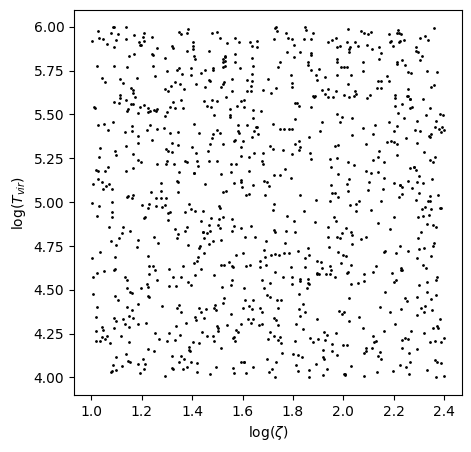

In [40]:
plt.figure(figsize=(5,5))
plt.scatter(np.log10(hii_vir_params_latin[:,0]), hii_vir_params_latin[:,1], s=1, c='k')
plt.xlabel('$\log(\zeta)$')
plt.ylabel('$\log(T_{vir})$')

Plot the corresponding ionization histories at three redshifts. The prior distribution of $x_{\mathrm{HI}}$ appears irregular and nontrivial in shape, which may pose challenges for training. This is one motivation for considering the two-step inference approach.

In [43]:
xH_prior = np.load('/home/dante/workspace/sdc/sdc_data/sbi_dataset/xH_z678.npy')

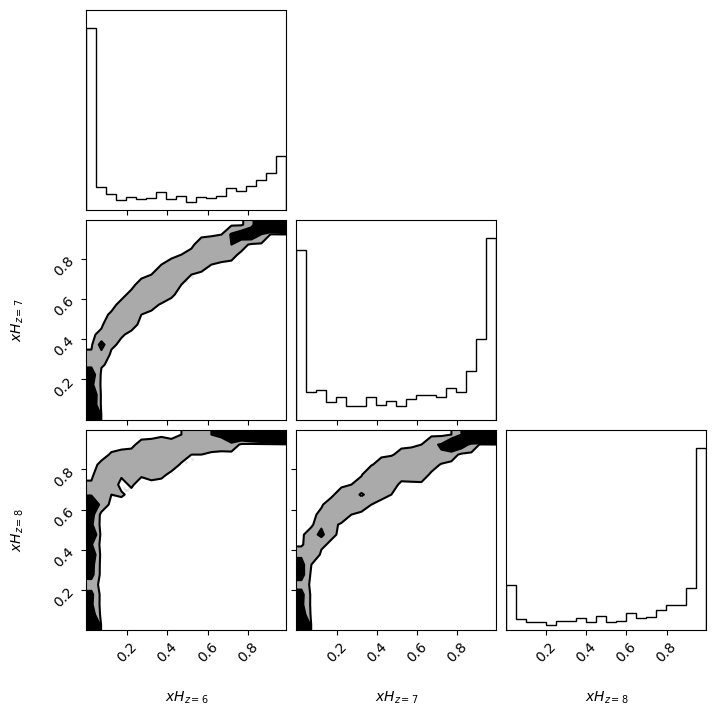

In [44]:
fig = corner(xH_prior, labels=[r'$xH_{z=6}$', r'$xH_{z=7}$', r'$xH_{z=8}$'], show_titles=False, title_kwargs={"fontsize": 12}, fill_contours=True, levels=(0.68, 0.99), plot_datapoints=True, color='black', alpha=0.5,label = 'Prior');

Plot all 2D power spectra in the training set.

In [45]:
ps2d_all = []
for i in range(1000):
    ps2d = np.load(f'/home/dante/workspace/sdc/sdc_data/ps2d/ps_{i}.npy')
    ps2d_all.append(ps2d)
ps2d_all = np.array(ps2d_all)

ps2d_all = np.transpose(ps2d_all, (0,1,3,2))

In [46]:
Pk_1_z_8 = np.loadtxt('/home/dante/workspace/sdc/sdc_data/taregt_data/PS1_PS2_Data/Pk_PS1_151.0_165.9.txt')
Pk_1_z_7 = np.loadtxt('/home/dante/workspace/sdc/sdc_data/taregt_data/PS1_PS2_Data/Pk_PS1_166.0_180.9.txt')
Pk_1_z_6 = np.loadtxt('/home/dante/workspace/sdc/sdc_data/taregt_data/PS1_PS2_Data/Pk_PS1_181.0_195.9.txt')

Pk_2_z_8 = np.loadtxt('/home/dante/workspace/sdc/sdc_data/taregt_data/PS1_PS2_Data/Pk_PS2_151.0_165.9.txt')
Pk_2_z_7 = np.loadtxt('/home/dante/workspace/sdc/sdc_data/taregt_data/PS1_PS2_Data/Pk_PS2_166.0_180.9.txt')
Pk_2_z_6 = np.loadtxt('/home/dante/workspace/sdc/sdc_data/taregt_data/PS1_PS2_Data/Pk_PS2_181.0_195.9.txt')

bins_par = np.loadtxt('/home/dante/workspace/sdc/sdc_data/taregt_data/PS1_PS2_Data/bins_kpar.txt')
bins_per = np.loadtxt('/home/dante/workspace/sdc/sdc_data/taregt_data/PS1_PS2_Data/bins_kper.txt')

test_data_1 = [Pk_1_z_8.T, Pk_1_z_7.T, Pk_1_z_6.T ]
test_data_2 = [Pk_2_z_8.T, Pk_2_z_7.T, Pk_2_z_6.T ]
test_data_1 = np.array(test_data_1)
test_data_2 = np.array(test_data_2)


In [47]:
ps2d_all_flat = ps2d_all.reshape(ps2d_all.shape[0], -1)
test_data_1_flat = test_data_1.flatten()
test_data_2_flat = test_data_2.flatten()

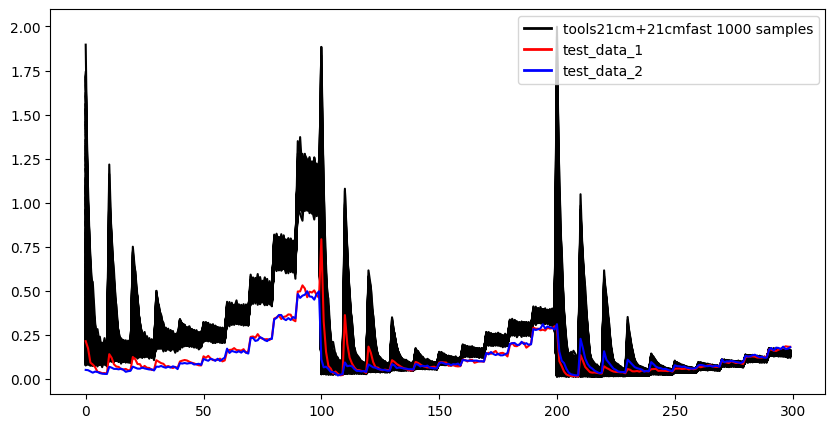

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(ps2d_all_flat.T, label='ps2d_all',color='black')
plt.plot(test_data_1_flat, label='test_data_1', color='red')
plt.plot(test_data_2_flat, label='test_data_2', color='blue' );
legend_handles = [plt.Line2D([0], [0], color='black', lw=2, label='tools21cm+21cmfast 1000 samples'),
                    plt.Line2D([0], [0], color='red', lw=2, label='test_data_1'),
                    plt.Line2D([0], [0], color='blue', lw=2, label='test_data_2')]
plt.legend(handles=legend_handles, loc='upper right')

It appears that the target datasets, PS1 and PS2, are out of distribution relative to the training set. We believe this discrepancy is primarily due to omitted observational effects—such as beam convolution—which can introduce a redshift-dependent normalization factor. **To mitigate this, we normalize the 2D power spectra at each redshift bin by dividing by the power at the lowest redshift bin**, effectively rescaling the spectra based on the largest-scale mode.

In [51]:
#norm at lowest k
ps2d_norm_at_mink = ps2d_all/ps2d_all[:,:,:1,:1] 
ps2d_norm_at_mink = ps2d_norm_at_mink.reshape(ps2d_norm_at_mink.shape[0], -1)
test_data_1_norm_at_mink = (test_data_1/test_data_1[:,:1,:1]).flatten()
test_data_2_norm_at_mink = (test_data_2/test_data_2[:,:1,:1]).flatten()

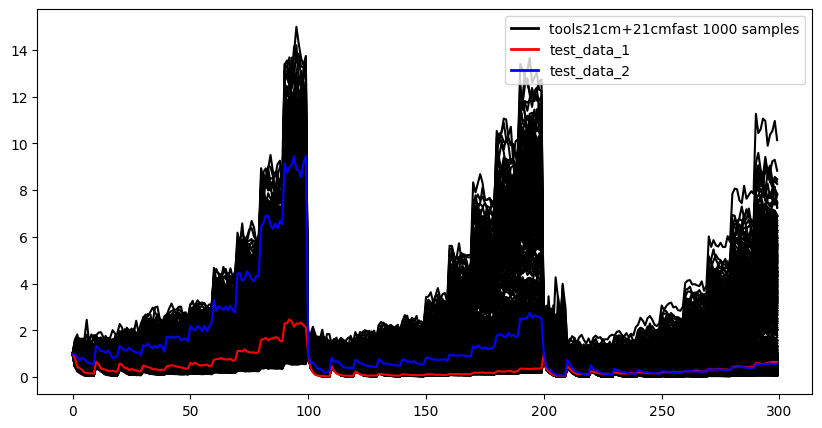

In [52]:
plt.figure(figsize=(10, 5))

plt.plot(ps2d_norm_at_mink.T, label='ps2d_all',color='black')
plt.plot(test_data_1_norm_at_mink, label='test_data_1', color='red')
plt.plot(test_data_2_norm_at_mink, label='test_data_2', color='blue' );
legend_handles = [plt.Line2D([0], [0], color='black', lw=2, label='tools21cm+21cmfast 1000 samples'),
                    plt.Line2D([0], [0], color='red', lw=2, label='test_data_1'),
                    plt.Line2D([0], [0], color='blue', lw=2, label='test_data_2')]
plt.legend(handles=legend_handles, loc='upper right')

As shown, both target datasets now fall within the distribution of the training data. This is the final dataset we used for training and inference.

## Infer xH from PS directly

In [ ]:
data = ps2d_norm_at_mink
params = xH_prior

Split data into training set and test set

In [45]:
from sklearn.model_selection import train_test_split

data_train, data_test, params_train, params_test = train_test_split(data, params, test_size=0.1, random_state=0)

In [46]:
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

import torch

In [47]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cpu


Define the NPE model: we use an ensemble of 10 Masked Autoregressive Flows (MAF).

In [49]:
loader = NumpyLoader(x=data_train, theta=params_train)

# define a prior
prior = ili.utils.Uniform(low=np.zeros(3),high=np.ones(3), device=device)

# instantiate your neural networks to be used as an ensemble
num_models = 10
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5) for _ in range(10)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir=None
)


In [50]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 10.


 Neural network successfully converged after 148 epochs.

INFO:root:Training model 2 / 10.


 Neural network successfully converged after 117 epochs.

INFO:root:Training model 3 / 10.


 Neural network successfully converged after 142 epochs.

INFO:root:Training model 4 / 10.


 Neural network successfully converged after 116 epochs.

INFO:root:Training model 5 / 10.


 Neural network successfully converged after 174 epochs.

INFO:root:Training model 6 / 10.


 Neural network successfully converged after 146 epochs.

INFO:root:Training model 7 / 10.


 Neural network successfully converged after 105 epochs.

INFO:root:Training model 8 / 10.


 Neural network successfully converged after 142 epochs.

INFO:root:Training model 9 / 10.


 Neural network successfully converged after 118 epochs.

INFO:root:Training model 10 / 10.


 Neural network successfully converged after 207 epochs.

INFO:root:It took 286.29466485977173 seconds to train models.


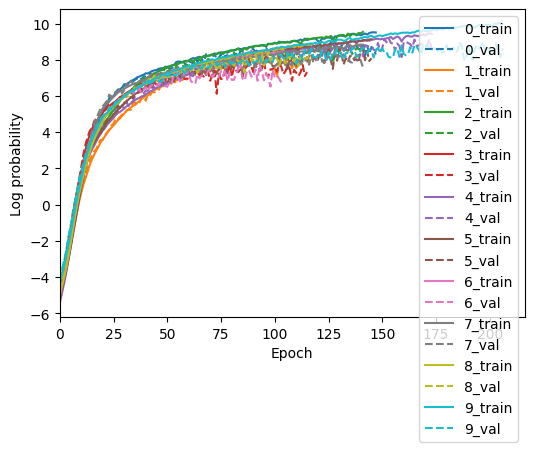

In [51]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

After training, evaluate the model on the test set by analyzing both individual posterior predictions and overall calibration performance.

Drawing 151 posterior samples:   0%|          | 0/151 [00:00<?, ?it/s]

Drawing 58 posterior samples:   0%|          | 0/58 [00:00<?, ?it/s]

Drawing 121 posterior samples:   0%|          | 0/121 [00:00<?, ?it/s]

Drawing 49 posterior samples:   0%|          | 0/49 [00:00<?, ?it/s]

Drawing 175 posterior samples:   0%|          | 0/175 [00:00<?, ?it/s]

Drawing 110 posterior samples:   0%|          | 0/110 [00:00<?, ?it/s]

Drawing 51 posterior samples:   0%|          | 0/51 [00:00<?, ?it/s]

Drawing 90 posterior samples:   0%|          | 0/90 [00:00<?, ?it/s]

Drawing 72 posterior samples:   0%|          | 0/72 [00:00<?, ?it/s]

Drawing 123 posterior samples:   0%|          | 0/123 [00:00<?, ?it/s]

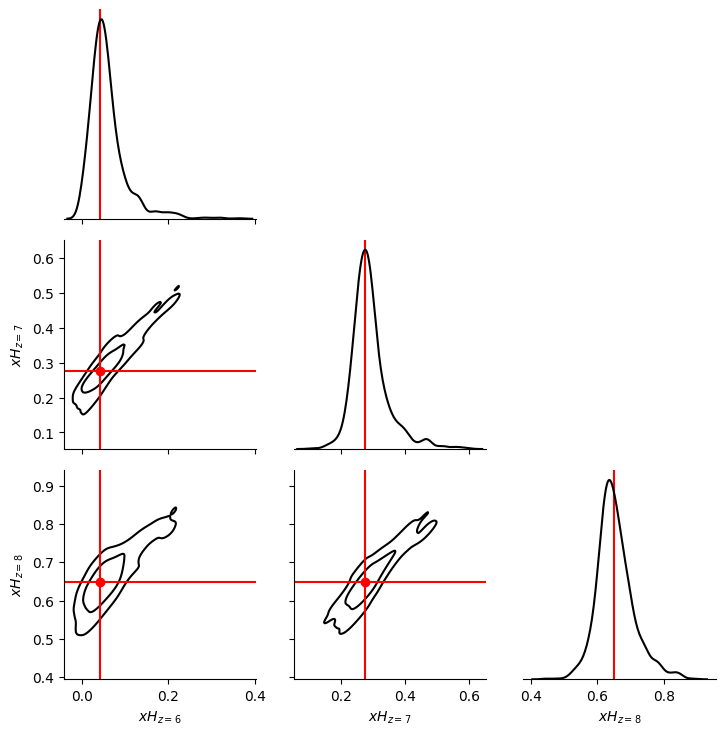

In [52]:
ind = np.random.randint(0, len(params_test))
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[r'$xH_{z=6}$', r'$xH_{z=7}$', r'$xH_{z=8}$']
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = data_test[ind], theta_fid=params_test[ind]
)

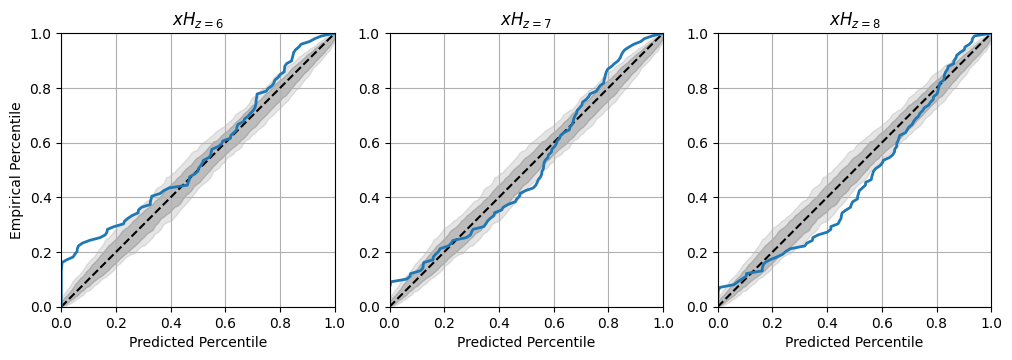

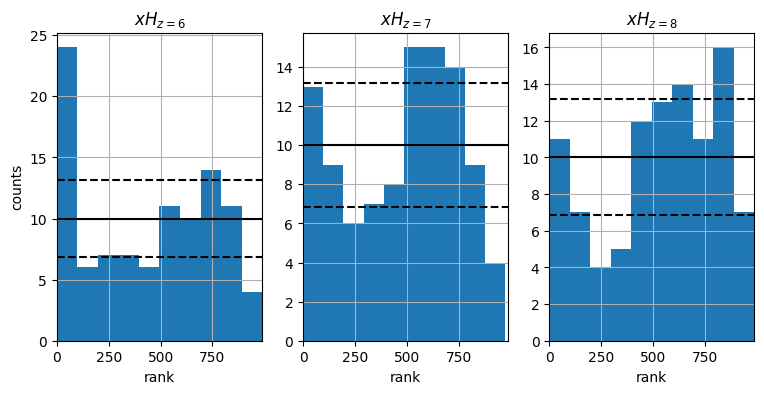

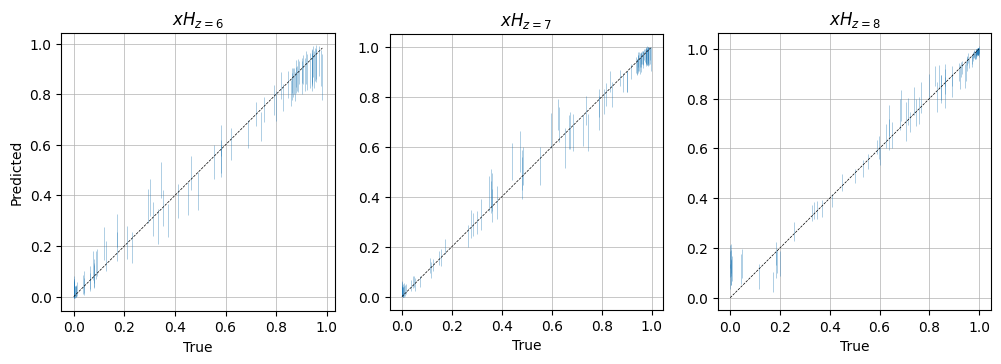

In [53]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=[r'$xH_{z=6}$', r'$xH_{z=7}$', r'$xH_{z=8}$'],
    plot_list = ["coverage", "histogram", "predictions"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=data_test, theta=params_test
)

In [ ]:
#save model 
torch.save(posterior_ensemble, '/home/dante/workspace/sdc/sdc_data/sbi_models/model_direct_xH.pth')

Apply the model to target data

Drawing 146 posterior samples:   0%|          | 0/146 [00:00<?, ?it/s]

Drawing 61 posterior samples:   0%|          | 0/61 [00:00<?, ?it/s]

Drawing 128 posterior samples:   0%|          | 0/128 [00:00<?, ?it/s]

Drawing 46 posterior samples:   0%|          | 0/46 [00:00<?, ?it/s]

Drawing 188 posterior samples:   0%|          | 0/188 [00:00<?, ?it/s]

Drawing 85 posterior samples:   0%|          | 0/85 [00:00<?, ?it/s]

Drawing 44 posterior samples:   0%|          | 0/44 [00:00<?, ?it/s]

Drawing 107 posterior samples:   0%|          | 0/107 [00:00<?, ?it/s]

Drawing 68 posterior samples:   0%|          | 0/68 [00:00<?, ?it/s]

Drawing 127 posterior samples:   0%|          | 0/127 [00:00<?, ?it/s]

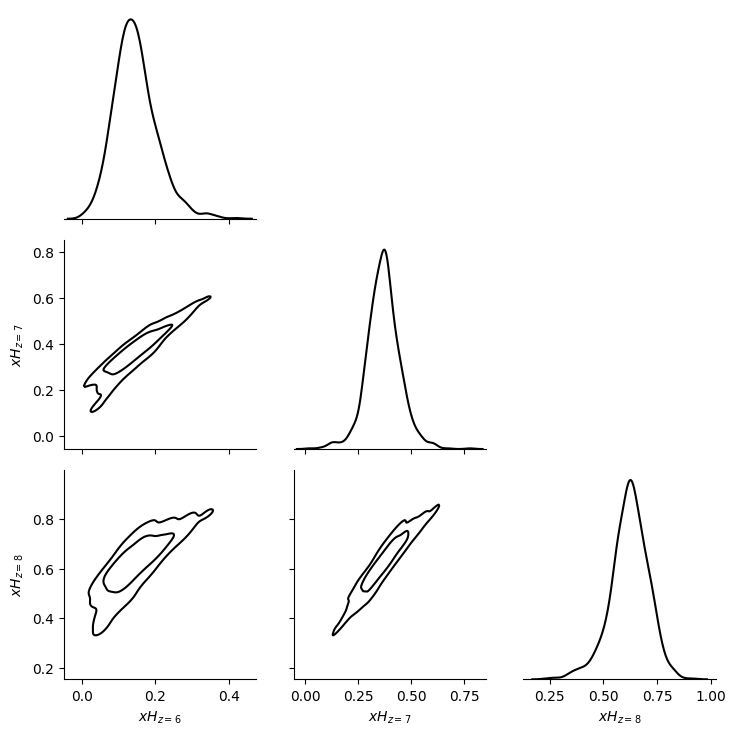

In [ ]:
ind = np.random.randint(0, len(params_test))
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[r'$xH_{z=6}$', r'$xH_{z=7}$', r'$xH_{z=8}$']
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = test_data_1_norm_at_mink, theta_fid=None
)

Drawing 139 posterior samples:   0%|          | 0/139 [00:00<?, ?it/s]

Drawing 71 posterior samples:   0%|          | 0/71 [00:00<?, ?it/s]

Drawing 138 posterior samples:   0%|          | 0/138 [00:00<?, ?it/s]

Drawing 40 posterior samples:   0%|          | 0/40 [00:00<?, ?it/s]

Drawing 170 posterior samples:   0%|          | 0/170 [00:00<?, ?it/s]

Drawing 102 posterior samples:   0%|          | 0/102 [00:00<?, ?it/s]

Drawing 55 posterior samples:   0%|          | 0/55 [00:00<?, ?it/s]

Drawing 78 posterior samples:   0%|          | 0/78 [00:00<?, ?it/s]

Drawing 69 posterior samples:   0%|          | 0/69 [00:00<?, ?it/s]

Drawing 138 posterior samples:   0%|          | 0/138 [00:00<?, ?it/s]

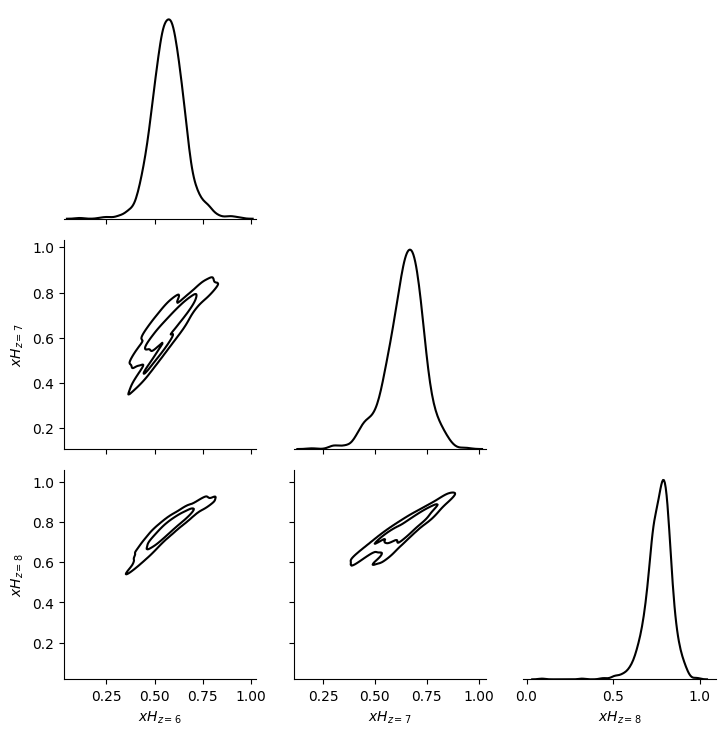

In [ ]:
ind = np.random.randint(0, len(params_test))
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[r'$xH_{z=6}$', r'$xH_{z=7}$', r'$xH_{z=8}$']
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = test_data_2_norm_at_mink, theta_fid=None
)

## Infer Reionization Parameters

Following the same procedure as the last section, we now focus on inferring the reionization parameters.

In [ ]:
data = np.load('/home/dante/workspace/sdc/sdc_data/sbi_dataset/ps2d_norm_at_mink.npy')
params = np.loadtxt('/home/dante/workspace/sdc/sdc_data/sbi_dataset/hii_vir_params.txt', delimiter=',', skiprows=1)
params[:,0] = np.log10(params[:,0])

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_test, params_train, params_test = train_test_split(data, params, test_size=0.1, random_state=0)

In [ ]:
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

import torch

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cpu


In [ ]:
loader = NumpyLoader(x=data_train, theta=params_train)

# define a prior
prior = ili.utils.Uniform(low=np.min(params,axis = 0),high=np.max(params,axis = 0), device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5) for _ in range(10)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir=None
)


In [ ]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 10.


 Neural network successfully converged after 90 epochs.

INFO:root:Training model 2 / 10.


 Neural network successfully converged after 92 epochs.

INFO:root:Training model 3 / 10.


 Neural network successfully converged after 68 epochs.

INFO:root:Training model 4 / 10.


 Neural network successfully converged after 70 epochs.

INFO:root:Training model 5 / 10.


 Neural network successfully converged after 66 epochs.

INFO:root:Training model 6 / 10.


 Neural network successfully converged after 69 epochs.

INFO:root:Training model 7 / 10.


 Neural network successfully converged after 61 epochs.

INFO:root:Training model 8 / 10.


 Neural network successfully converged after 69 epochs.

INFO:root:Training model 9 / 10.


 Neural network successfully converged after 82 epochs.

INFO:root:Training model 10 / 10.


 Neural network successfully converged after 82 epochs.

/work/dante/miniconda3/envs/21cmfast/lib/python3.8/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 149.3029932975769 seconds to train models.


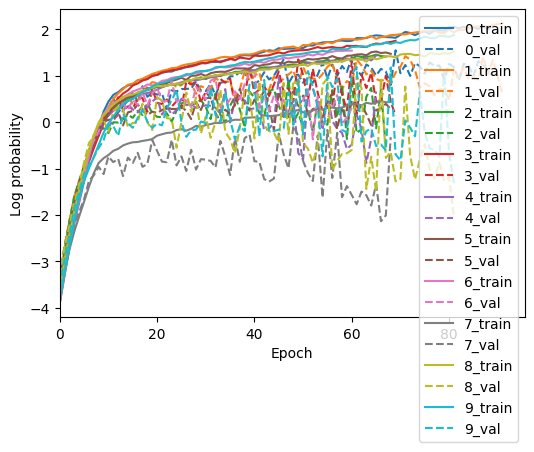

In [ ]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

Drawing 172 posterior samples:   0%|          | 0/172 [00:00<?, ?it/s]

Drawing 127 posterior samples:   0%|          | 0/127 [00:00<?, ?it/s]

Drawing 87 posterior samples:   0%|          | 0/87 [00:00<?, ?it/s]

Drawing 119 posterior samples:   0%|          | 0/119 [00:00<?, ?it/s]

Drawing 81 posterior samples:   0%|          | 0/81 [00:00<?, ?it/s]

Drawing 74 posterior samples:   0%|          | 0/74 [00:00<?, ?it/s]

Drawing 101 posterior samples:   0%|          | 0/101 [00:00<?, ?it/s]

Drawing 33 posterior samples:   0%|          | 0/33 [00:00<?, ?it/s]

Drawing 102 posterior samples:   0%|          | 0/102 [00:00<?, ?it/s]

Drawing 104 posterior samples:   0%|          | 0/104 [00:00<?, ?it/s]

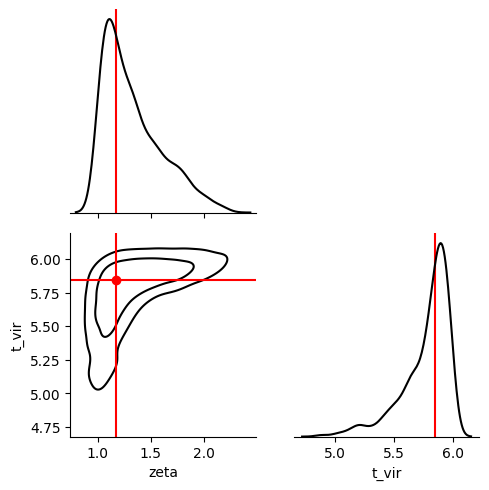

In [ ]:
ind = np.random.randint(0, len(params_test))
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=['zeta', 't_vir']
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = data_test[ind], theta_fid=params_test[ind]
)

100%|██████████| 100/100 [00:10<00:00,  9.75it/s]


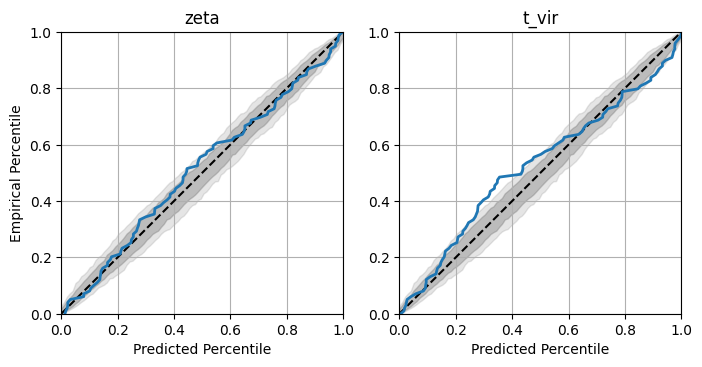

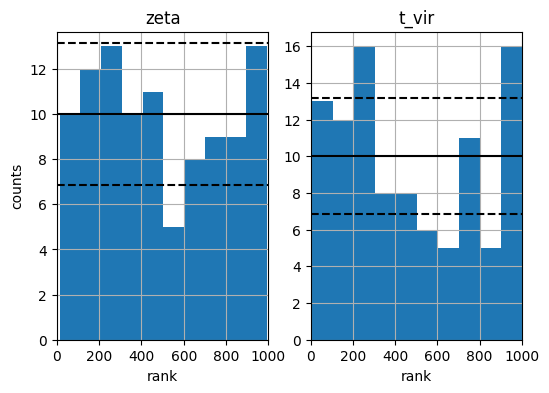

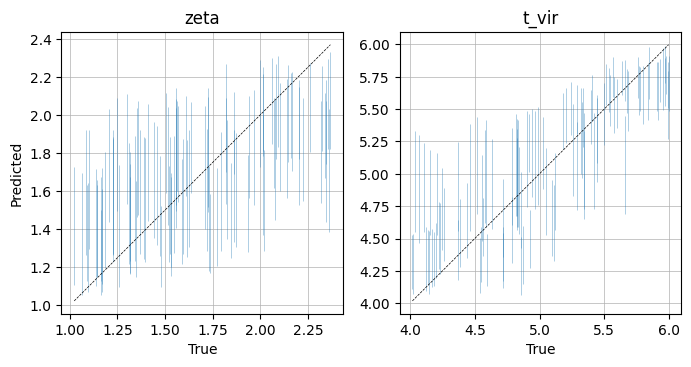

In [ ]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=['zeta', 't_vir'],
    plot_list = ["coverage", "histogram", "predictions"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=data_test, theta=params_test
)

Drawing 150 posterior samples:   0%|          | 0/150 [00:00<?, ?it/s]

Drawing 149 posterior samples:   0%|          | 0/149 [00:00<?, ?it/s]

Drawing 74 posterior samples:   0%|          | 0/74 [00:00<?, ?it/s]

Drawing 118 posterior samples:   0%|          | 0/118 [00:00<?, ?it/s]

Drawing 87 posterior samples:   0%|          | 0/87 [00:00<?, ?it/s]

Drawing 80 posterior samples:   0%|          | 0/80 [00:00<?, ?it/s]

Drawing 103 posterior samples:   0%|          | 0/103 [00:00<?, ?it/s]

Drawing 29 posterior samples:   0%|          | 0/29 [00:00<?, ?it/s]

Drawing 96 posterior samples:   0%|          | 0/96 [00:00<?, ?it/s]

Drawing 114 posterior samples:   0%|          | 0/114 [00:00<?, ?it/s]

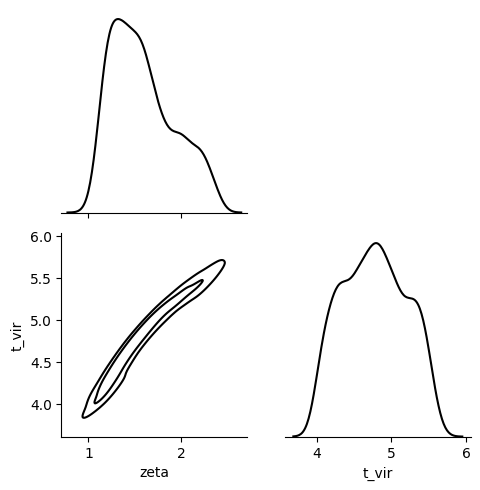

In [ ]:
ind = np.random.randint(0, len(params_test))
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=['zeta', 't_vir']
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = test_data_1_norm_at_mink, theta_fid=None
)

Drawing 169 posterior samples:   0%|          | 0/169 [00:00<?, ?it/s]

Drawing 126 posterior samples:   0%|          | 0/126 [00:00<?, ?it/s]

Drawing 92 posterior samples:   0%|          | 0/92 [00:00<?, ?it/s]

Drawing 129 posterior samples:   0%|          | 0/129 [00:00<?, ?it/s]

Drawing 85 posterior samples:   0%|          | 0/85 [00:00<?, ?it/s]

Drawing 73 posterior samples:   0%|          | 0/73 [00:00<?, ?it/s]

Drawing 109 posterior samples:   0%|          | 0/109 [00:00<?, ?it/s]

Drawing 37 posterior samples:   0%|          | 0/37 [00:00<?, ?it/s]

Drawing 75 posterior samples:   0%|          | 0/75 [00:00<?, ?it/s]

Drawing 105 posterior samples:   0%|          | 0/105 [00:00<?, ?it/s]

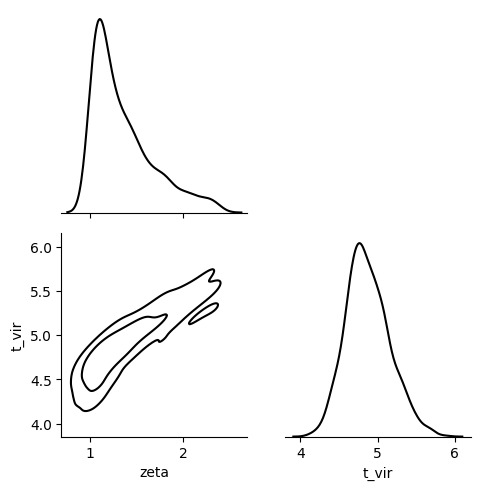

In [ ]:
ind = np.random.randint(0, len(params_test))
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=['zeta', 't_vir']
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = test_data_2_norm_at_mink, theta_fid=None
)

Note that all reionization parameters sampled from the posterior will be converted to $x_{\mathrm{HI}}$ by running forward simulations.